# About

In [10]:
# only for development, can be removed later
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Text about organization of our code and this notebook

# Prerequisites 

(tbd) This notebook assumes that you:

- have internet access
- have a Google identity
- have configured a project under Google Cloud Platform (you can see how to complete this step in this tutorial)
- replace ##MY_PROJECT_ID## in the cell below with the ID of the GCP project you have confugured under your account

In [2]:
my_project_id = "idc-pathomics-000"

# Environment setup

In [3]:
curr_dir = !pwd
curr_droid = !hostname
curr_pilot = !whoami

print("Current directory :", curr_dir[-1])
print("Hostname          :", curr_droid[-1])
print("Username          :", curr_pilot[-1])

Current directory : /home/jupyter/idc-pathomics-use-case-1/src
Hostname          : idc-patho-vm
Username          : jupyter


In [26]:
!sudo apt-get update
!sudo apt-get install --no-install-recommends -y python3-openslide
!sudo pip3 install -r ../requirements_cptac.txt # at the end, check whether all are required, maybe no requirement file needed, when only one/two things are installed
!pip install wandb -qqq # monitoring tool 

Hit:1 http://security.debian.org/debian-security buster/updates InRelease
Hit:2 http://deb.debian.org/debian buster InRelease                            
Hit:3 http://deb.debian.org/debian buster-updates InRelease                    
Hit:4 http://deb.debian.org/debian buster-backports InRelease                  
Hit:5 https://nvidia.github.io/libnvidia-container/stable/debian10/amd64  InRelease
Hit:6 https://download.docker.com/linux/debian buster InRelease                
Hit:7 https://nvidia.github.io/nvidia-container-runtime/stable/debian10/amd64  InRelease
Hit:8 https://nvidia.github.io/nvidia-docker/debian10/amd64  InRelease
Hit:9 http://packages.cloud.google.com/apt cloud-sdk-buster InRelease
Hit:11 https://packages.cloud.google.com/apt google-fast-socket InRelease
Hit:12 http://packages.cloud.google.com/apt google-cloud-packages-archive-keyring-buster InRelease
Get:10 https://packages.cloud.google.com/apt kubernetes-xenial InRelease [9383 B]
Hit:13 http://packages.cloud.google.c

In [4]:
# Import all required python libraries for this use case
import os
import sys
sys.path.append('/usr/local/lib/python3.7/dist-packages') # otherwise Openslide can not be loaded. Maybe find a better solution?!
import time
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import wandb

In [5]:
# Create directories for input and output data 
input_dir = '/home/jupyter/idc_input/'
output_dir = '/home/jupyter/idc_output/'
os.mkdir(input_dir)
os.mkdir(output_dir)

FileExistsError: [Errno 17] File exists: '/home/jupyter/idc_input/'

# Dataset selection and exploration

## Dataset selection using BigQuery

IDC relies on the Google Cloud Platform (GCP) for storage and management of DICOM data. The data are contained in so-called [storage buckets](https://cloud.google.com/storage/docs/key-terms#buckets), from which they are available for the user on a requester pays basis. Currently, all pathology whole-slide images (WSI) are located in the `tbd` bucket.
**Metadata** for the DICOM files - including standard DICOM tags, but also non-DICOM metadata - are stored in BigQuery tables from which they can easily be accessed using standard SQL queries. This gives users the opportunity to explore available data by examining metadata without the need of downloading the DICOM data in the first place. Additional information on the organization of data can be found in the [IDC Documentation](https://learn.canceridc.dev/data/organization-of-data). 

The easiest way to acess BigQuery tables from within a Jupyter notebook is to use the [BigQuery cell magic](https://cloud.google.com/bigquery/docs/visualize-jupyter#querying-and-visualizing-bigquery-data) provided by the BigQuery client library for Python. 
Using the `%%bigquery` command as shown below, the results of the following SQL query are stored as pandas data frame `cohort_df`.   
Further information on how to use BigQuery within the IDC, on the attributes available and examples can be found [here](https://learn.canceridc.dev/cookbook/bigquery). 

In [8]:
%%bigquery cohort_df --project=$my_project_id 

WITH slide_images AS (
    SELECT
        ContainerIdentifier AS slide_id,
        PatientID AS patient_id,
        ClinicalTrialProtocolID AS dataset,
        TotalPixelMatrixColumns AS width,
        TotalPixelMatrixRows AS height,
        gcs_url,
        CAST(SharedFunctionalGroupsSequence[OFFSET(0)].
             PixelMeasuresSequence[OFFSET(0)].
             PixelSpacing[OFFSET(0)] AS FLOAT64) AS pixel_spacing,
        CASE TransferSyntaxUID
            WHEN '1.2.840.10008.1.2.4.50' THEN 'jpeg'
            WHEN '1.2.840.10008.1.2.4.91' THEN 'jpeg2000'
            ELSE 'other'
        END AS compression
    FROM idc-dev-etl.idc_v3.dicom_all
    WHERE NOT (ContainerIdentifier IS NULL)
)
SELECT *
FROM slide_images
WHERE
    (compression = "jpeg")
    AND (dataset = "CPTAC-LUAD" OR dataset = "CPTAC-LSCC")
    -- pixel spacing between 0.00025 and 0.00051 mm corresponds to 20x magnification
    AND (pixel_spacing > 0.00025) AND (pixel_spacing < 0.00051)

Downloading: 100%|██████████| 2211/2211 [00:01<00:00, 1444.15rows/s]


Since up to now the information about the slide's tissue type (tumor tissue or normal tissue) is missing in the BQ table, we have to extract those from the attached TCIA metadata file and add them to our cohort's metadata. We remove slides that have no tissue type information available from our cohort. 

In [19]:
from data.utils import attach_tissue_type_information

tissue_type_data = pd.read_csv(os.path.join(input_dir, 'tissue_type_data_TCIA.csv'))
slides_metadata = attach_tissue_type_information(cohort_df, tissue_type_data)
slides_metadata_path = os.path.join(input_dir, 'slides_metadata.csv')
slides_metadata.to_csv(slides_metadata_path, index=False) # Save slides metadata as csv for later use

## Dataset exploration 

Using pandas and matplotlib functionality the user can quite easily have a look at the selected cohort's metadata and visualize some aspects of interest: 

In [18]:
print('Total number of slides in this cohort: ', len(slides_metadata))
nr_slides_from_luad_patients = slides_metadata.groupby('cancer_subtype').size()['luad'] # or len(slides_metadata[slides_metadata['cancer_subtype'] == 'luad']) 
nr_slides_from_lscc_patients = slides_metadata.groupby('cancer_subtype').size()['lscc'] # or len(slides_metadata[slides_metadata['cancer_subtype'] == 'lscc'])
nr_luad_patients = slides_metadata.drop_duplicates('patient_id').groupby('cancer_subtype').size()['luad']
nr_lscc_patients = slides_metadata.drop_duplicates('patient_id').groupby('cancer_subtype').size()['lscc']
print('--> %d slides from %d LUAD patients' %(nr_slides_from_luad_patients, nr_luad_patients))
print('--> %d slides from %d LSCC patients' %(nr_slides_from_lscc_patients, nr_lscc_patients))

slides_metadata.head()

Total number of slides in this cohort:  2129
--> 1056 slides from 229 LUAD patients
--> 1073 slides from 211 LSCC patients


,slide_id,patient_id,cancer_subtype,tissue_type,width,height,gcs_url,pixel_spacing,compression
0,93e30fd5-e57e-4503-a175-863c7d_D1_D1,11LU016,luad,tumor,55775,48446,gs://idc_dev/51036e43-5622-41a9-af03-603cf2127...,0.000494,jpeg
1,C3L-00095-26,C3L-00095,luad,normal,27887,24718,gs://idc_dev/72cf9b5f-d467-4a86-9fc6-b9272cc42...,0.000494,jpeg
2,C3L-00412-21,C3L-00412,luad,tumor,33863,32867,gs://idc_dev/54fa081e-e62e-4df2-8f0f-5bd1424d4...,0.000494,jpeg
3,C3L-00568-23,C3L-00568,lscc,tumor,19919,18390,gs://idc_dev/80ec2c0e-e246-4a0d-bfcb-3c3d5f31c...,0.000494,jpeg
4,C3L-00893-21,C3L-00893,luad,tumor,19919,19138,gs://idc_dev/bd709e68-45be-4059-944a-4a42fa096...,0.000494,jpeg


Having ~1000 slides from ~200 patients for each cancer subtype, means that there are on average 5 whole-slide images per patient. The left plot below provides more detailed information in form of a histogram. 

**Important:** From almost every patient (LUAD or LSCC), not only tumor tissue but both tumor tissue and healthy ("normal") tissue samples were collected. The right graph below reveals that in LUAD and LSCC, about one-third of the slides were derived from healthy tissue, while the other two-thirds were derived from cancer tissue. 

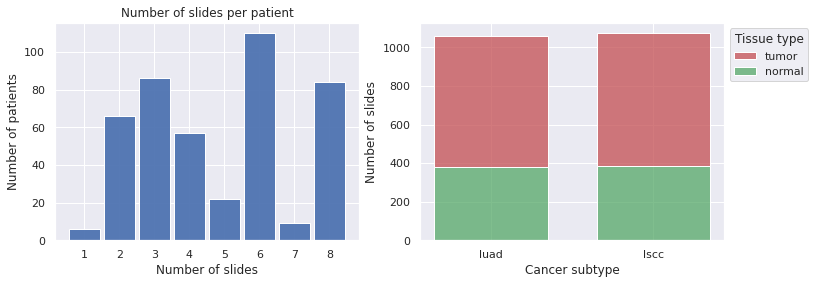

In [74]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# How many slides per patient? --> maybe also distinguish between luad and lscc pattients
slides_per_patient = slides_metadata.groupby(['patient_id', 'cancer_subtype']).size()
ax1 = sns.histplot(data=slides_per_patient, discrete=True, ax=ax1, shrink=0.9)
ax1.set_title('Number of slides per patient')
ax1.set_xlabel('Number of slides')
ax1.set_ylabel('Number of patients')

# Displaying tissue type distribution 
#print(slides_metadata.groupby(['cancer_subtype', 'tissue_type']).size())
plot = sns.histplot(data=slides_metadata, x='cancer_subtype', hue='tissue_type', palette=['r','g'], multiple='stack', ax=ax2, shrink=0.7)
ax2.set_xlabel('Cancer subtype')
ax2.set_ylabel('Number of slides')
legend = plot.get_legend()
legend.set_title('Tissue type')
legend.set_bbox_to_anchor((1, 1))

In [ ]:
# IDC viewer for some pathomics data? 
def get_idc_viewer_url(study_UID):
    return "https://viewer.imaging.datacommons.cancer.gov/viewer/" + study_UID

# Pathomics use case

Text about experiments we are going to perfom 

## Preprocessing

Explanatory text 

In [6]:
from data.tile_generation_cptac import generate_tiles

slides_dir = os.path.join(input_dir, 'cptac_slides')
tiles_dir = os.path.join(input_dir, 'cptac_tiles')
#os.makedir(slides_dir)
#os.makedir(tiles_dir)

#generate_tiles(slides_dir, os.path.join(input_dir, 'slides_metadata.csv'), tiles_dir, 'idc-pathomics-000')

#os.remove(slides_dir) # delete because this directory is now empty and no longer required

In [24]:
from data.tile_sorting_cptac import sort_tiles

sort_tiles(tiles_dir, slides_metadata_path, input_dir, 'norm_cancer')
sort_tiles(tiles_dir, slides_metadata_path, input_dir, 'luad_lscc')
sort_tiles(tiles_dir, slides_metadata_path, input_dir, 'norm_luad_lscc')

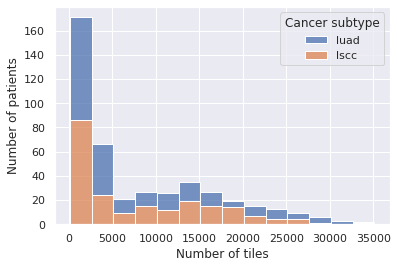

In [62]:
# How many tiles per patient (due to different size of slides) --> explain patient metadata as intermediate result of sorting 
patient_metadata = pd.read_csv(os.path.join(input_dir, 'patient_metadata.csv'))
ax = sns.histplot(data=patient_metadata, x='nr_tiles_total', hue='cancer_subtype', multiple='stack', binwidth=2500)
ax.set_xlabel('Number of tiles')
ax.set_ylabel('Number of patients')
legend = ax.get_legend()
legend.set_title('Cancer subtype')

In [20]:
# Create smaller training sets (1/10 of the tiles) --> fo all three experiments? 
!sed -n '1p;0~20p' "$input_dir/train_norm_luad_lscc.csv" > "$input_dir/train_norm_luad_lscc_smaller.csv"
!sed -n '1p;0~20p' "$input_dir/valid_norm_luad_lscc.csv" > "$input_dir/valid_norm_luad_lscc_smaller.csv"
!sed -n '1p;0~20p' "$input_dir/test_norm_luad_lscc.csv" > "$input_dir/test_norm_luad_lscc_smaller.csv"

## Training

In [16]:
wandb.login()
run = wandb.init()

wandb: Currently logged in as: daniela_ (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.12.0 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
2021-08-11 12:52:32.345558: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.11.0
2021-08-11 12:52:33.573294: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libnvinfer.so.7
2021-08-11 12:52:33.575085: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libnvinfer_plugin.so.7


In [17]:
from data.data_set import Dataset
from model.inceptionv3_model import InceptionModel

output_dir_experiment = os.path.join(output_dir, time.strftime("%Y%m%d_%H%M%S"))
os.mkdir(output_dir_experiment)

dataset_train = Dataset(os.path.join(input_dir, 'train_norm_luad_lscc_smaller.csv'), num_classes=3)
dataset_valid = Dataset(os.path.join(input_dir, 'valid_norm_luad_lscc_smaller.csv'), num_classes=3)
model = InceptionModel(num_classes=3, input_shape=(128,128,3), learning_rate=0.01)
#print(model)

model.train(dataset_train, batch_size=128, epochs=10, output_path=output_dir_experiment, validation_dataset=dataset_valid)
model.save(output_dir_experiment)
# how to select best model or simply take final model here? 
# best_model = 


InvalidVersionSpec: Invalid version '1.0<2': invalid character(s)



Train for 974 steps, validate for 217 steps
Epoch 1/10
973/974 [============================>.] - ETA: 0s - loss: 0.8146 - auc_1: 0.8389

2021-08-11 13:08:34.134806: W tensorflow/python/util/util.cc:319] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: /home/jupyter/idc_output/20210811_125239/checkpoint_001/assets
974/974 [==============================] - 971s 997ms/step - loss: 0.8146 - auc_1: 0.8389 - val_loss: 0.8385 - val_auc_1: 0.8291
Epoch 2/10
973/974 [============================>.] - ETA: 0s - loss: 0.6508 - auc_1: 0.8872

2021-08-11 13:23:10.630341: W tensorflow/core/kernels/data/generator_dataset_op.cc:103] Error occurred when finalizing GeneratorDataset iterator: Cancelled: Operation was cancelled


INFO:tensorflow:Assets written to: /home/jupyter/idc_output/20210811_125239/checkpoint_002/assets
974/974 [==============================] - 950s 976ms/step - loss: 0.6507 - auc_1: 0.8873 - val_loss: 0.6356 - val_auc_1: 0.8932
Epoch 3/10
973/974 [============================>.] - ETA: 0s - loss: 0.5730 - auc_1: 0.9099

2021-08-11 13:38:59.898214: W tensorflow/core/kernels/data/generator_dataset_op.cc:103] Error occurred when finalizing GeneratorDataset iterator: Cancelled: Operation was cancelled


INFO:tensorflow:Assets written to: /home/jupyter/idc_output/20210811_125239/checkpoint_003/assets
974/974 [==============================] - 949s 974ms/step - loss: 0.5729 - auc_1: 0.9099 - val_loss: 0.6794 - val_auc_1: 0.8756
Epoch 4/10
973/974 [============================>.] - ETA: 0s - loss: 0.5425 - auc_1: 0.9192

2021-08-11 13:54:49.323859: W tensorflow/core/kernels/data/generator_dataset_op.cc:103] Error occurred when finalizing GeneratorDataset iterator: Cancelled: Operation was cancelled


INFO:tensorflow:Assets written to: /home/jupyter/idc_output/20210811_125239/checkpoint_004/assets
974/974 [==============================] - 951s 976ms/step - loss: 0.5425 - auc_1: 0.9192 - val_loss: 0.9447 - val_auc_1: 0.8641
Epoch 5/10
973/974 [============================>.] - ETA: 0s - loss: 0.5331 - auc_1: 0.9225

2021-08-11 14:10:39.927132: W tensorflow/core/kernels/data/generator_dataset_op.cc:103] Error occurred when finalizing GeneratorDataset iterator: Cancelled: Operation was cancelled


INFO:tensorflow:Assets written to: /home/jupyter/idc_output/20210811_125239/checkpoint_005/assets
974/974 [==============================] - 949s 975ms/step - loss: 0.5330 - auc_1: 0.9225 - val_loss: 0.7601 - val_auc_1: 0.8716
Epoch 6/10
 57/974 [>.............................] - ETA: 13:16 - loss: 0.5092 - auc_1: 0.9290

KeyboardInterrupt: 

In [19]:
run.finish()

## Evaluation

In [75]:
from data.data_set import Dataset
from model.inceptionv3_model import InceptionModel
output_dir_experiment = '/home/jupyter/idc_output/20210810_165740'
best_model = 'checkpoint_003'
model = InceptionModel.load(os.path.join(output_dir_experiment, best_model))

In [ ]:
from evaluation.predictions import Predictions

test_dataset = Dataset(os.path.join(input_dir, 'test_norm_luad_lscc_small.csv'), num_classes=3)
predictions = Predictions(model, test_dataset) 
predictions.save(os.path.join(output_dir_experiment, 'predictions_testset.json'))

In [ ]:
from evaluation.roc import ROCAnalysis

roc_analysis = ROCAnalysis(predictions, experiment='norm_luad_lusc')
roc_analysis.plot(output_dir_experiment) # make an inline plot
roc_analysis.print_and_save_tabluar_results(os.path.join(output_dir_experiment, 'results_table.html'))

In [ ]:
from evaluation.heatmap import Heatmap 

colormaps=['coolwarm', 'coolwarm', 'coolwarm']
hm = Heatmap(predictions, 'TCGA-68-8250-01A-01-TS1.d6347fc6-c657-4d0f-bba9-09efde4991f3', colormaps)
hm.plot(os.path.join(output_dir_experiment, 'heatmap.png'))

## Notes for improvement
- vielleicht ueberall funktionsparameter benennen zur besseren verstaendlichkeit**
- where to explain that we use gcl_url to download slides and tile them then? 